In [25]:
%matplotlib inline
%autosave 300
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)
import wave
import pyaudio
from audio2numpy import open_audio
from IPython.display import Audio
from scipy import signal
from scipy.fftpack import fft,fftshift
from scipy.io.wavfile import write
from scipy.signal import  firwin, freqz, firwin2, butter, lfilter

Autosaving every 300 seconds


### adsr example

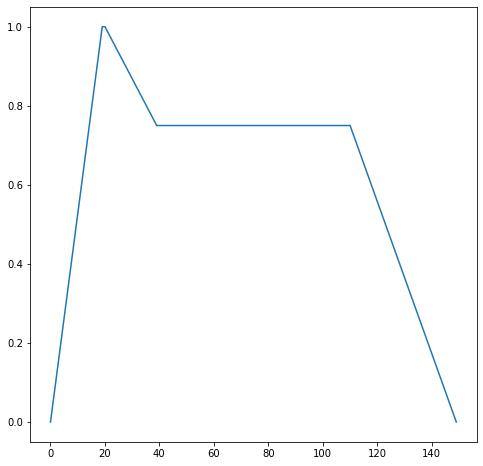

In [2]:
# ADSREXAMPLE
# This script creates a linear ADSR amplitude envelope
#
# See also ADSR

# Number of Samples per fade
a = 20
d = 20
s = 70
r = 40

sustainAmplitude = 0.75

# Create each segment A,D,S,R
aFade = np.linspace(0,1,a)
dFade = np.linspace(1,sustainAmplitude,d)
sFade = sustainAmplitude * np.ones(s)
rFade = np.linspace(sustainAmplitude,0,r)


#Concactenates total ADSR envelope
env = np.concatenate((aFade,dFade,sFade,rFade))

plt.plot(env)

### adsr

In [4]:
# ADSR
# This function can be used to apply an
# adsr envelope on to an input signal.
#
# Input Variables
#   attackTime : length of attack ramp in milliseconds
#   decayTime : length of decay ramp in ms
#   sustainAmplitude : linear amplitude of sustain segment
#   releaseTime : length of release ramp in ms

def adsr( x,Fs,attackTime,decayTime,sustainAmplitude,releaseTime): 

    #Convert time inputs to seconds 
    attackTimeS = attackTime / 1000
    decayTimeS = decayTime / 1000
    releaseTimeS = releaseTime / 1000

    #Convert seconds to samples and determine sustain time
    a = round(attackTimeS * Fs)     # Round each to an integer
    d = round(decayTimeS * Fs)      # number of samples
    r = round(releaseTimeS * Fs)
    s = len(x) - (a+d+r)       # Determine length of sustain

    #Create linearly spaced fades for A,D, and R. Creates hold for S
    aFade = np.linspace(0,1,a)
    dFade = np.linspace(1,sustainAmplitude,d)
    sFade = sustainAmplitude * np.ones(s)
    rFade = np.linspace(sustainAmplitude,0,r)

    #Concactenates total ADSR curve
    adsr = np.concatenate((aFade,dFade,sFade,rFade))

    #Applies ADSR shaping to X
    y = x * adsr

    return y

### feedback lpf

In [13]:
# This script plots the frequency response
# of the LPF used in an amplitude envelope analysis
alpha = 0.9995 # Gain on the feedback path
b = [1-alpha] # Feedforward coefficients
a = [1 , -alpha] # Feedback coefficients
w,h = signal.freqz(b,a) # Frequency response of the LPF

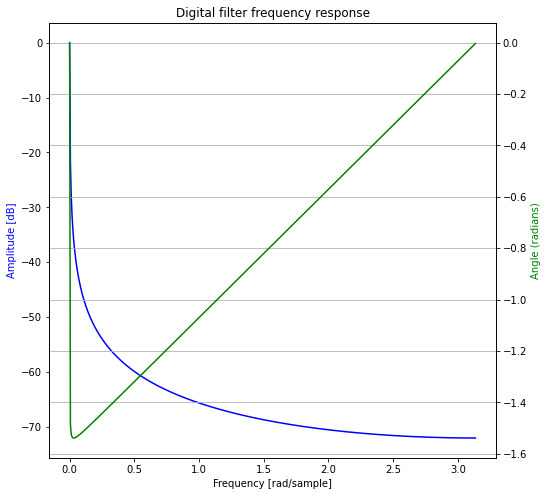

In [14]:
fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency response')
ax1.plot(w, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [rad/sample]')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid()
ax2.axis('tight')
plt.show()

### envelope modulation

In [23]:
# ENVELOPEMODULATION
# This script demonstrates the process of measuring an
# amplitude envelope from the waveform of a voice recording
# and using it modulate the amplitude of synth recording.

# Import Audio Files
filename = "textbookcode-master\Ch_17\Voice.wav"
[inx,Fs] = open_audio(filename)
[synth,_] = open_audio('textbookcode-master\Ch_17\Synth.wav')

alpha = 0.9997 # Feed-back gain
fb = 0         # Initialized value for feedback
N = len(inx)
env = np.zeros(N)

for n in range(N):
    # Analyze envelope
    env[n] = (1-alpha) * abs(inx[n]) + alpha * fb
    fb = env[n]
    
# Make-up Gain
env = 4*env

# Amplitude Modulation of envelope applied to synthsizer
out = synth*env

Audio(out,rate=Fs)

### vocoder example

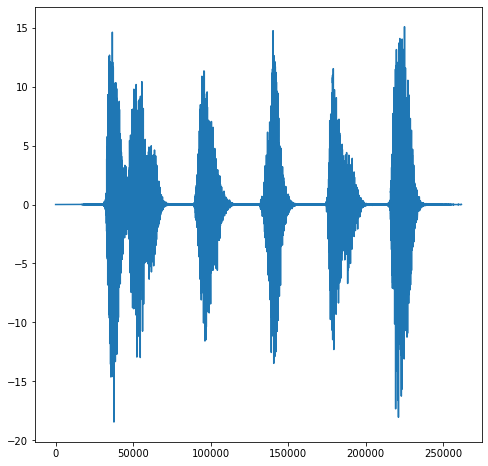

In [40]:
# VOCODEREXAMPLE
# This script demonstrates the process of creating
# a vocoder effect using a Voice signal and
# Synth signal


# Import Audio Files
filename = "textbookcode-master\Ch_17\Voice.wav"
[inx,Fs] = open_audio(filename)
[synth,_] = open_audio('textbookcode-master\Ch_17\Synth.wav')

# Initialize filter parameters
Nyq = Fs/2   # Nyquist frequency
order = 2    # Filter order

numOfBands = 16

# Logarithmically space cut-off frequencies
# 2*10^1 - 2*10^4 (20-20k) Hz
freq = 2 * np.logspace(1,4,numOfBands+1)

g = 0.9992 # Smoothing Filter Gain
fb = 0     # Initialize feedback delay 

N = len(inx)

# These arrrays are used to store the filtered
# versions of the input signal. Each column stores
# the signal for each band. As an example, 
# voxBands(:,4) stores the band-pass filtered
# signal in 4th band. 
voxBands = np.zeros((N,numOfBands))
synthBands = np.zeros((N,numOfBands))
envBands = np.zeros((N,numOfBands))

for band in range(numOfBands): # Perform processing 1 band per loop
   
    # Determine lower and upper cut-off frequencies
    # of the current BPF on a normalized scale.
    Wn = np.array(freq[band] , freq[band+1]) / Nyq
          
    b,a = signal.butter(order,Wn)
    
    # Filter signals and store the result 
    voxBands[:,band] = lfilter(b,a,inx)
    synthBands[:,band] = lfilter(b,a,synth)
    
    # Envelope measurement from vocal signal
    for n in range (N):
    
        envBands[n,band] = (1-g) * np.abs(voxBands[n,band]) + g * fb
        fb = envBands[n,band]
    
    fb = 0

# Perform Amplitude Modulation
outBands = np.zeros((len(inx),numOfBands))
          
for band in range(numOfBands):
    
    # Apply the envelope of the vocal signal to the synthesizer
    # in each of the bands
    outBands[:,band] = envBands[:,band] * synthBands[:,band] 
    

# Sum together all the bands
out = np.sum(outBands,axis=1)
# Make-up Gain
out = 32 * out


plt.plot(out)

In [41]:
# Listen to the output and plot it
Audio(out,rate=Fs)

### ci simulation

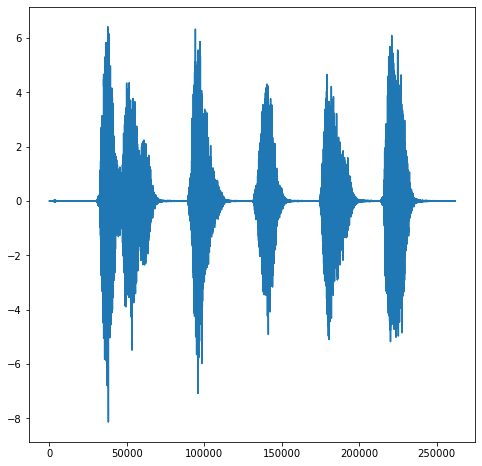

In [47]:
# CISIMULATION
# This script performs vocoding
# using speech and white noise. This process
# is used to simulate cochlear implants
# for listeners with acoustic hearing

# See also VOCODEREXAMPLE

# Import Audio Files
filename = "textbookcode-master\Ch_17\Voice.wav"
[inx,Fs] = open_audio(filename)

N = len(inx)
noise = 0.1 * np.random.randn(N)

# Initialize filter parameters
Nyq = Fs/2
order = 2 # Filter Order

numOfBands = 16

# Logarithmically space cut-off frequencies
# 2*10^1 - 2*10^4 (20-20k) Hz
freq = 2 * np.logspace(1,4,numOfBands+1)

g = 0.9992 # Smoothing Filter Gain
fb = 0     # Initialize feedback delay 

voxBands = np.zeros((N,numOfBands))
noiseBands = np.zeros((N,numOfBands))
envBands = np.zeros((N,numOfBands))

for band in range(numOfBands):
   
    Wn = np.array(freq[band] , freq[band+1]) / Nyq      
    b,a = signal.butter(order,Wn)
    
    # Filterbank
    voxBands[:,band] = lfilter(b,a,inx)
    noiseBands[:,band] = lfilter(b,a,noise)
    
    # Envelope Measurement
    for n in range (N):
    
        envBands[n,band] = (1-g) * abs(voxBands[n,band]) + g * fb
        fb = envBands[n,band]
    
    fb = 0

# Perform Amplitude Modulation
outBands = np.zeros((len(inx),numOfBands))
for band in range (numOfBands):
   
    outBands[:,band] = envBands[:,band] * noiseBands[:,band] 
    

# Sum together all the bands
out = np.sum(outBands,axis=1)
# Make-up Gain
out = 32 * out

plt.plot(out);

In [46]:
Audio(out,rate=Fs)

### envelope wah

In [48]:
# BIQUADWAH
# This function can be used to create a Wah-wah audio effect
#
# Input Variables
#   in : single sample of the input signal
#   Fs : sampling rate
#   env : used to determine the frequency of LPF
#   ff : buffer for feed-foward delay
#   fb : buffer for feed-back delay
#   wet : percent of processed signal (dry = 100 - wet)
#
# Use Table 13.1 to Caculate LPF Bi-quad Coefficients
#
# See also ENVWAHEXAMPLE

def biquadWah(inx,Fs,env,Q,ff,fb,wet):

    # Convert value of ENV to normalized frequency
    w0 = 2*np.pi*env/Fs
    # Normalize Bandwidth
    alpha = np.sin(w0)/(2*Q)

    b0 = (1-np.cos(w0))/2
    a0 = 1+alpha
    b1 = 1-np.cos(w0)
    a1 = -2*np.cos(w0)
    b2 = (1-np.cos(w0))/2
    a2 = 1-alpha

    # Wet/Dry Mix
    mixPercent = wet  # 0 = Only Dry, 100 = Only Wet
    mix = mixPercent/100

    # Store Dry and Wet Signals
    drySig = inx 

    # Low-pass Filter
    wetSig = (b0/a0)*inx + (b1/a0)*ff[0] + (b2/a0)*ff[1] - (a1/a0)*fb[0] - (a2/a0)*fb[1]

    # Blend Parallel Paths
    out = (1-mix)*drySig + mix*wetSig

    # Iterate Buffers for Next Sample
    ff[1] = ff[0]
    ff[0] = inx
    fb[1] = fb[0]
    fb[0] = wetSig

    return out,ff,fb

In [49]:
# ENVWAHEXAMPLE
# This script implements an env-wah effect using
# a bi-quad filter as the resonant LPF after 
# analyzing the amplitude envelope of the input
# signal. 
#
# See also BIQUADWAH

filename = "textbookcode-master\Ch_13\AcGtr.wav"
[x,Fs] = open_audio(filename)

Ts = 1/Fs
N = len(x)

# Initialize Feed-forward Delay Buffer 
# (stores 2 previous samples of input)
ff = np.array([0 , 0]) # ff(n,1) = n-samples of delay  

# Initialize Feed-back Delay Buffer 
# (stores 2 previous samples of output)
fb = np.array([0, 0]) # fb(n,1) = n-samples of delay

# Bandwidth of resonant LPF
Q = 4

# Wet/Dry Mix
wet = 100

# Initialize Output Signal
y = np.zeros(N)
# Cut-off frequency from envelope
cutoff = np.zeros(N)  

# Envelope LPF Parameters
alpha = 0.9995
envPreviousValue = 0

for n in range(N):
    # Envelope Detection
    rect = np.abs(x[n])
    env = (1-alpha) * rect + (alpha)*envPreviousValue
    envPreviousValue = env
    
    # Scale Envelope for Cut-off Frequency of LPF
    freq = 1500 + 10000 * env
    
    # Use Bi-quad Wah Effect Function
    y[n],ff,fb = biquadWah(x[n],Fs,freq,Q,ff,fb,wet)
    # Store for Plotting
    cutoff[n] = freq

In [50]:
Audio(y,rate=Fs)

Text(0, 0.5, 'Cut-off Freq. (Hz)')

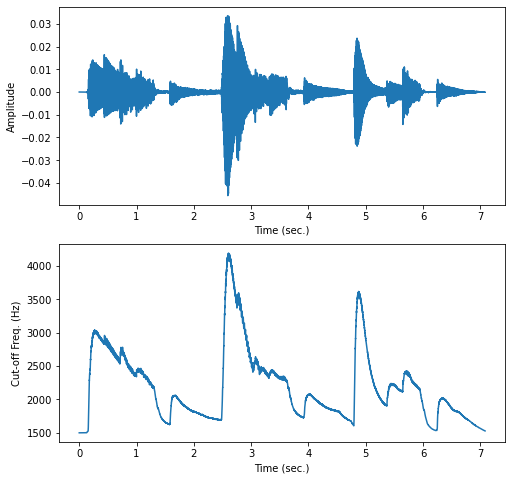

In [54]:
t= np.arange(0,N)*Ts

plt.subplot(2,1,1)
plt.plot(t,y)
plt.xlabel('Time (sec.)')
plt.ylabel('Amplitude')
plt.subplot(2,1,2)
plt.plot(t,cutoff)
plt.xlabel('Time (sec.)')
plt.ylabel('Cut-off Freq. (Hz)')

### transient analysis

(1.0, 312346.0, -0.5, 1.0)

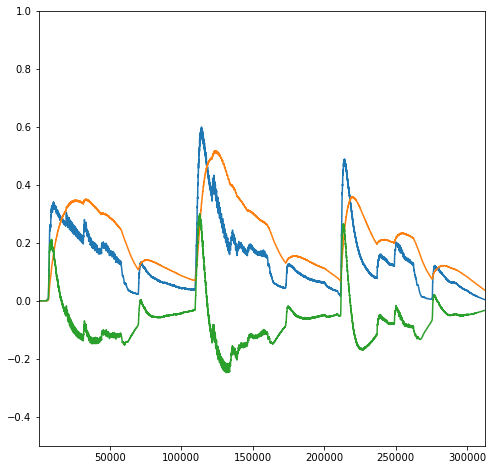

In [56]:
# TRANSIENTANALYSIS
# This script plots the amplitude envelopes used
# in the transient designer effect. A comparison
# is plotted of the "fast" and "slow" envelopes
# used to determine when "attack" and "sustain"
# is occurring in the signal.
#
# See also TRANSIENTDESIGNER, TRANSIENTEXAMPLE

filename = "textbookcode-master\Ch_13\AcGtr.wav"
[inx,Fs] = open_audio(filename)

gFast = 0.9991 # Gain smoothing for the "fast" envelope
fbFast = 0     # Feed-back for the "fast" envelope
gSlow = 0.9999 # Gain smoothing for the "slow" envelope 
fbSlow = 0     # Feed-back for the "slow" envelope    

N = len(inx)
envFast = np.zeros(N)
envSlow = np.zeros(N)
transientShaper = np.zeros(N)

for n in range(N):
    
    envFast[n] = (1-gFast) * 2 * np.abs(inx[n]) + gFast * fbFast
    fbFast = envFast[n]
    
    envSlow[n] = (1-gSlow) * 3 * np.abs(inx[n]) + gSlow * fbSlow
    fbSlow = envSlow[n]
    
    transientShaper[n] = envFast[n] - envSlow[n]

plt.figure(1)
plt.plot(envFast)
plt.plot(envSlow) 
plt.plot(transientShaper)
#legend({'$\alpha$ = 0.9991','$\alpha$ = 0.9999', ...
 #   'envFast - envSlow'},'Interpreter','latex','FontSize',14);
plt.axis([1, len(inx), -0.5, 1])

(1.0, 312346.0, 0.5, 1.5)

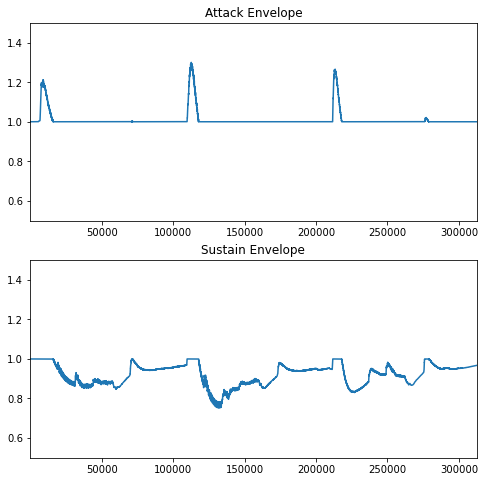

In [58]:
attack = np.zeros(N)
sustain = np.zeros(N)

for n in range(N):
   
    if transientShaper[n] > 0:
        
        attack[n] = transientShaper[n] + 1
        sustain[n] = 1
    else:        
        attack[n] = 1
        sustain[n] = transientShaper[n] + 1
        

plt.figure(2);
plt.subplot(2,1,1)  # Plot the detected attack envelope
plt.plot(attack)
plt.title('Attack Envelope')
plt.axis([1, len(inx), 0.5, 1.5])
plt.subplot(2,1,2) #% Plot the detected sustain envelope
plt.plot(sustain)
plt.title('Sustain Envelope')
plt.axis([1, len(inx), 0.5, 1.5])

### transient example

In [60]:
# TRANSIENTDESIGNER
# This function implements the transient designer
# audio effect. First, a detection analysis is performed
# to determine the sections of the signal which should 
# be labeled "attack" and "sustain". Then the amplitude
# of these sections is scaled based on the input parameters

# Input Variables
#   attack : amount to change transient (-1 dec, 0 unity, +1 inc)
#   sustain : amount to change sustain

# See also TRANSIENTANALYSIS


def transientDesigner(inx,attack,sustain):

    N = len(inx)
    # Initialize Filtering Parameters
    gFast = 0.9991   # Feed-back gain for the "fast" envelope
    fbFast = 0       # Variable used to store previous envelope value
    gSlow = 0.9999   # Feed-back gain for "slow" envelope
    fbSlow = 0
    envFast = np.zeros(N)
    envSlow = np.zeros(N)
    differenceEnv = np.zeros(N)

    # Measure Fast and Slow Envelopes
    for n in range(N):

        envFast[n] = (1-gFast) * 2 * abs(inx[n]) + gFast * fbFast
        fbFast = envFast[n]

        envSlow[n] = (1-gSlow) * 3 * abs(inx[n]) + gSlow * fbSlow
        fbSlow = envSlow[n]

        # Create the difference envelope between "fast" and "slow"
        differenceEnv[n] = envFast[n] - envSlow[n]
        
        # Note: difference envelope will have a positive value
        # when envFast is greater than envSlow. This occurs
        # when the signal is in "attack". If the difference
        # envelope is negative, then the signal is in
        # "sustain".

    attEnv = np.zeros(N)
    susEnv = np.zeros(N)
    
    # Separate Attack and Sustain Envelopes
    for n in range(N):

        if differenceEnv[n] > 0: # "Attack" section

            attEnv[n] = (attack * differenceEnv[n]) + 1
            susEnv[n] = 1 # No change

        else: # "Sustain" section

            attEnv[n] = 1 # No change
            susEnv[n] = (sustain * -differenceEnv[n]) + 1

    # Apply the Attack and Sustain Envelopes
    out = (inx * attEnv) * susEnv

    return out

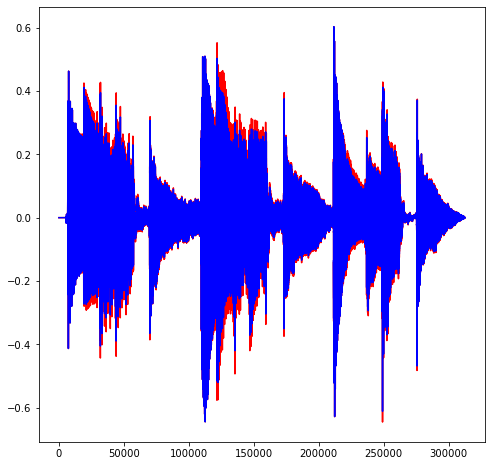

In [79]:
# TRANSIENTEXAMPLE
# This script demonstrates the Transient Designer function

# See also TRANSIENTDESIGNER, TRANSIENTANALYSIS

filename = "textbookcode-master\Ch_13\AcGtr.wav"
[inx,Fs] = open_audio(filename)

# Attack and Sustain Parameters [-1,+1]
attack = 0
sustain = 1

out = transientDesigner(inx,attack,sustain)

plt.plot(out,'r')
plt.plot(inx,'b')

In [80]:
Audio(out,rate=Fs)

In [76]:
Audio(inx,rate=Fs)